## Tensorflow Probability - Exploring MCMC   
### Day 9/100 Days of TensorFlow Probability  

So far, we have been avoiding looking at the full-Bayesian workflow for Tensorflow Probability. Today, we dive in and explore Hamiltonian Monte Carlo. This is the first day that we have attempted to grapple with the full syntax of tfp - and it has been a fun challenge!

We're going to take it slowly. I'll build up the framework for running a MCMC model to start with, then we'll look at some simple examples.

### MCMC Framework  

It seems to take a lot of code to run a simple MCMC experiment. However, once I wrapped my head around it - it wasn't as bad as I first thought. There are actually only three important components:  

  - define the joint log posterior (this is the most important part!)  
  - define the MCMC chain (we'll use Hamiltonian Monte Carlo)  
  - run the chain  
  
It's actually quite simple, so I'm not sure why it looks so complicated. We've drawn our code here from two places:  

  - [Bayesian Methods for Hackers, Chpt 2](https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter2_MorePyMC/Ch2_MorePyMC_TFP.ipynb)  
  - TFP Documentation for [HMC](https://www.tensorflow.org/probability/api_docs/python/tfp/mcmc/HamiltonianMonteCarlo)  
  

The joint log posterior function is the most important, and so we will leave this for later. Instead, let's start by defining a reasonably vanilla HMC and a function to run the chain. We'll parameterise the log posterior function so that we can just switch these out for different experiments.

First though, a little setup. I've taken the reset_sess() code straight from Bayesian Methods for Hackers:

In [0]:
import collections
import numpy as np
import seaborn as sns

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

try:
  tf.compat.v1.enable_eager_execution()
except ValueError:
  pass

import matplotlib.pyplot as plt

from __future__ import print_function

def reset_sess(config=None):
    """
    Convenience function to create the TF graph & session or reset them.
    """
#     if config is None:
#         config = session_options(enable_gpu_ram_resizing=True, enable_xla=False)
    global sess
    tf.reset_default_graph()
    try:
        sess.close()
    except:
        pass
    sess = tf.InteractiveSession(config=config)

reset_sess()


Next, let's define our HMC and the `run_chain()` convenience function. I am going to parameterise the length of the chain (the number of iterations it will run for), simply so that we can increase the length of the chains later on.

In [0]:
# global parameteres
NUM_POSTERIOR_SAMPLES = 5000
NUM_BURNIN_ITERATIONS = 2000
NUM_ADAPTATION = int(0.5 * NUM_BURNIN_ITERATIONS)


def construct_hmc(log_posterior, adaptation_steps = NUM_ADAPTATION):
  
  """
  Define a reaonsably "vanilla" HMC chain.
  
  Parameters
  ----------
    @log_posterior: function of the joint posterior distribution
    
  """  
  
  hmc = tfp.mcmc.SimpleStepSizeAdaptation(

      # The actual HMC is very simple to define
      tfp.mcmc.HamiltonianMonteCarlo(
          target_log_prob_fn = log_posterior,    # Log Posterior goes here
          num_leapfrog_steps = 3,
          step_size = 1                          # constant step size
      ),
      num_adaptation_steps = adaptation_steps
  )
  
  return hmc

@tf.function
def run_chain(hmc, inits=[], iters = [NUM_POSTERIOR_SAMPLES, NUM_BURNIN_ITERATIONS]):
  
  """
  Extract samples from HMC chain
  
  Parameters
  ----------
    @hmc: a MonteCarlo chain (returned from construct_hmc())
    @initial_state: starting point for the chain
    @iters: list [length of chain, burnin iterations]
    
  Returns
  -------
    samples: list of posterior samples for each parameter estimated
    
  """
  samples, is_accepted = tfp.mcmc.sample_chain(
      num_results = iters[0],
      num_burnin_steps = iters[1],
      current_state = inits,
      kernel = hmc
  )
  
  return samples

That's actually all we need in terms of machinery to run a chain. It's quite straight-forward. The "magic" is in defining the joint-log-posterior. There are a couple of good resources to help grok the joint_log_prob:

  - [Tensorflow Notebook](https://github.com/tensorflow/probability/blob/master/discussion/joint_log_prob.md)  
  - [Bayesian Methods for Hackers, Chpt 2](https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter2_MorePyMC/Ch2_MorePyMC_TFP.ipynb)  
  
Bayesian Methods for Hackers, Chpt 2 has a great breakdown of the joint_log_prob. This function is the posterior from Bayes Theorem. I vaguely remember that Bayesian inference is based on the following:  

$posterior \propto prior * likelihood$  

And *this* is exactly what the joint_log_prob defines, with a structure a little like the following:

```
def joint_log_prob(data, parameters):

    priors = ...
    likelihood = p(y | model)  # initially the model is the priors, but it will adapt with our parameters
    
    return (
       priors.log_prob(parameters) +   # how likely are our parameters under the priors?
                                       # this "pulls" or estimates back towards the priors, but will be
                                       # ultimately overwhelmed by the data
       likelihood.log_prob(data)       # how likely are our data, given the likelihood?
    )
```

It all lookst quite simple really :)  Let's go through some examples.


### Experiment One: Estimating a Binomial rate  

Let's start with a single parameter, a Binomial rate. We'll simulate some coin tosses with a known rate, and see if we can estimate something close to this. Here is our `joint_log_prob()` function:

In [0]:
def joint_log_prob(data, rate):
  """
  Estimate the rate of a Bernoulli process.
  
  Parameters
  ----------
    @data: the observed data, binary (0, 1)
    @rate: the "machinery" will pass this in for us.
           This is the parameter we are attempting to estimate
  """
  
  prior_rate = tfd.Uniform(0., 1.)          # start with a uniform prior
  rv_data = tfd.Bernoulli(probs = rate)     # rate will adapt as it learns
  
  return (
      prior_rate.log_prob(rate) +           # the prior
      tf.reduce_sum(rv_data.log_prob(data)) # the likelihoo: 
                                            #   how likely are our data
                                            #   under the assumed model?
  )

unnormalized_posterior = lambda rate: joint_log_prob(data, rate)

The only "trick" above is the definition of the `unnormalized_posterior`. This is also a function, but it marginalises out the parameters we are estimating. So, you simply remove the data from it's parameters and make sure that you name each of the parameters you are estimating instead. 

I don't really understand this... but it seems to be what is required.

Right, let's simulate some data with a rate of 0.7 and see if we can retrieve this rate:

/usr/local/lib/python3.6/dist-packages/tensorflow_probability/python/mcmc/sample.py:335: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn("Tracing all kernel results by default is deprecated. Set "


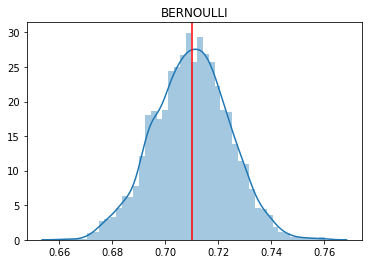

In [18]:
reset_sess()

generator = tfd.Bernoulli(probs=0.7)
data = generator.sample(1000)

# NOTE initialisation below, if you initialise too close to zero
# it doesn't learn!
[rate_] = run_chain(construct_hmc(unnormalized_posterior), inits=[0.5])

sns.distplot(rate_)
#plt.hist(rate_, bins=50, alpha= 0.7)
plt.axvline(x = np.mean(data), color='red')
plt.title("BERNOULLI")
plt.show()

Nice :) This might be very, very simple - but it is a step on the road. Very happy with this.

### Experiment Two: Poisson Rate  

Let's try another example. This will also be a singe-parameter problem, a poisson rate.

/usr/local/lib/python3.6/dist-packages/tensorflow_probability/python/mcmc/sample.py:335: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn("Tracing all kernel results by default is deprecated. Set "


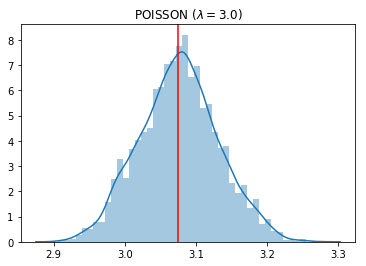

In [20]:
def joint_log_prob(data, rate):
  """
  Estimate the rate of a Poisson process.
  
  Parameters
  ----------
    @data: the observed data, binary (0, 1)
    @rate: the "machinery" will pass this in for us.
           This is the parameter we are attempting to estimate
  """
  
  prior_rate = tfd.HalfCauchy(loc=1., scale=5.)   
  rv_data = tfd.Poisson(rate = rate)       
  
  return (
      prior_rate.log_prob(rate) +  
      tf.reduce_sum(rv_data.log_prob(data)) 
  )

unnormalized_posterior = lambda rate: joint_log_prob(data, rate)


# Run the chain
reset_sess()

data = tfd.Poisson(rate=3).sample(1000).numpy()

# Again, note the initial estimate for the rate
# A lot of the documentation has you set this to the empircal mean
# But here, we just set it to 1.0. Less than this leads to slow learning.
[rate_] = run_chain(construct_hmc(unnormalized_posterior), inits=[1.0])

sns.distplot(rate_)
plt.axvline(x = np.mean(data), color='red')
plt.title("POISSON ($\lambda = 3.0)$")
plt.show()

Again, this is great. Note, that I had to experiment a bit with the init value to get this to work (try making it small, like 0.01).  

### Experiment 3: Normal Distribution  

This time, let's try to estimate two parameters at once: the mean and variance of a normal distribution.

/usr/local/lib/python3.6/dist-packages/tensorflow_probability/python/mcmc/sample.py:335: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn("Tracing all kernel results by default is deprecated. Set "


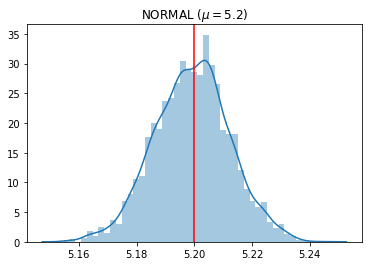

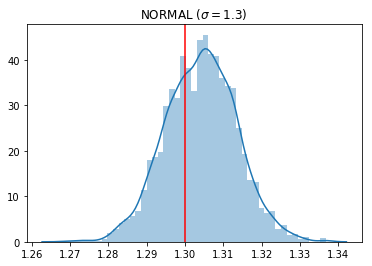

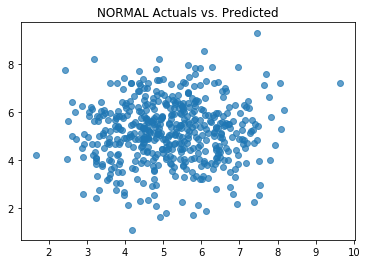

In [32]:
reset_sess()

def joint_log_prob(data, mu, sigma):
  """
  Estimate the mean and variance of a Normal distribution.
  
  Parameters
  ----------
    @data: the observed data, binary (0, 1)
    @mu:   the mean parameter. This is "learnable"
    @sigma: the variance parameter. This is "learnable"
  """
  
  prior_mu = tfd.Normal(loc = 0., scale = 1.0)
  prior_sigma = tfd.HalfCauchy(loc=0., scale=1.)
  rv_data = tfd.Normal(loc=mu, scale=sigma)
  
  return (
      prior_mu.log_prob(mu) +
      prior_sigma.log_prob(sigma) +
      tf.reduce_sum(rv_data.log_prob(data)) 
  )

unnormalized_posterior = lambda mu, sigma: joint_log_prob(data, mu, sigma)

generator = tfd.Normal(loc = 5.2, scale = 1.3)
data = generator.sample(10000).numpy()

[mu_, sigma_] = run_chain(construct_hmc(unnormalized_posterior), inits=[5.0, 1.0])

sns.distplot(mu_)
plt.axvline(x = 5.2, color='red')
plt.title("NORMAL ($\mu=5.2$)")
plt.show()

sns.distplot(sigma_)
plt.title("NORMAL ($\sigma=1.3$)")
plt.axvline(x = 1.3, color='red')
plt.show()

plt.scatter(np.random.choice(data, 500, replace = True), 
            np.random.normal(loc = np.mean(mu_), scale = np.mean(sigma_), size = 500),
           alpha = 0.7)
plt.title("NORMAL Actuals vs. Predicted")
plt.show()

Awesome - that really wasn't any trickier than our simpler methods. I am going to continue along these lines and estimate various univariate distributions. This will become a bit of a cheat sheet for me for later :)  

### Experiment 4: Beta distribution  

The beta distribution is parametised by $\alpha, \beta$.

Note, the odd parameterisation of the HalfNormal(scale) distribution. The [documentation](https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/HalfNormal) shows:

```
__init__(
    scale,
    validate_args=False,
    allow_nan_stats=True,
    name='HalfNormal'
)
```

/usr/local/lib/python3.6/dist-packages/tensorflow_probability/python/mcmc/sample.py:335: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn("Tracing all kernel results by default is deprecated. Set "


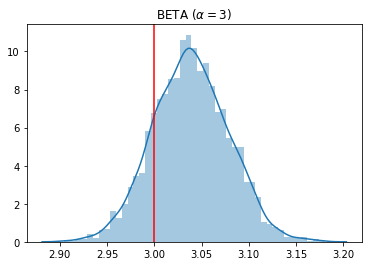

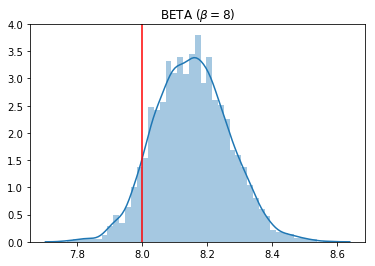

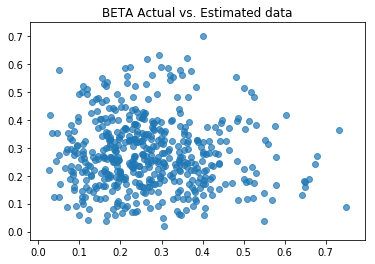

In [47]:
reset_sess()

def joint_log_prob(data, alpha, beta):
  """
  Estimate teh concentration parameters of a Beta distribution.
  
  Parameters
  ----------
    @data: the observed data, binary (0, 1)
    @alpha: learnable
    @beta: learnable
  """
  
  prior_alpha = tfd.HalfNormal(1.)
  prior_beta = tfd.HalfNormal(1.)
  rv_data = tfd.Beta(alpha, beta)
  
  return (
      prior_alpha.log_prob(alpha) +
      prior_beta.log_prob(beta) +
      tf.reduce_sum(rv_data.log_prob(data)) 
  )

unnormalized_posterior = lambda alpha, beta: joint_log_prob(data, alpha, beta)

generator = tfd.Beta(3, 8)
data = generator.sample(10000).numpy()

[alpha_, beta_] = run_chain(construct_hmc(unnormalized_posterior), inits=[2.0, 7.0])

sns.distplot(alpha_)
plt.axvline(x = 3.0, color='red')
plt.title("BETA ($\\alpha=3$)")
plt.show()

sns.distplot(beta_)
plt.axvline(x=8.0, color='red')
plt.title("BETA ($\\beta=8$)")
plt.show()

plt.scatter(
    np.random.choice(data, 500, replace = True),
    tfd.Beta(np.mean(alpha_), np.mean(beta_)).sample(500).numpy(),
    alpha = 0.7
)
plt.title("BETA Actual vs. Estimated data")
plt.show()

Getting the hang of this now. 

### Experiment 5: Gamma Distribution  



/usr/local/lib/python3.6/dist-packages/tensorflow_probability/python/mcmc/sample.py:335: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn("Tracing all kernel results by default is deprecated. Set "


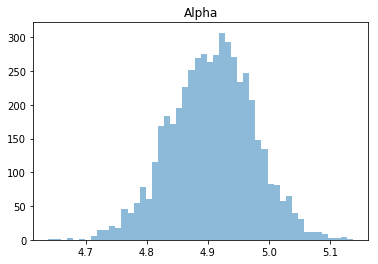

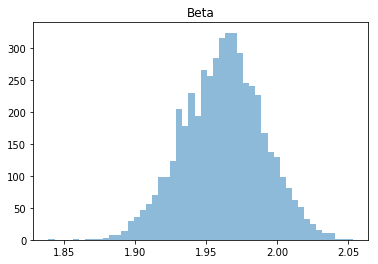

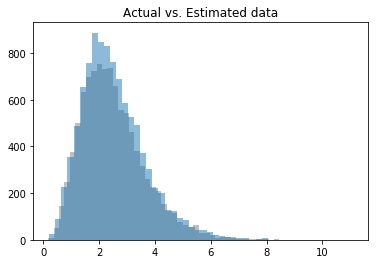

In [0]:
reset_sess()

def joint_log_prob(data, alpha, beta):
  """
  Estimate the concentration and rate of a Gamma distribution.
  
  Parameters
  ----------
    @data: the observed data, binary (0, 1)
    @alpha: learnable
    @beta: learnable
  """
  
  prior_alpha = tfd.HalfNormal(1.)
  prior_beta = tfd.HalfNormal(1.)
  rv_data = tfd.Gamma(concentration=alpha, rate=beta)
  
  return (
      prior_alpha.log_prob(alpha) +
      prior_beta.log_prob(beta) +
      tf.reduce_sum(rv_data.log_prob(data)) 
  )

unnormalized_posterior = lambda alpha, beta: joint_log_prob(data, alpha, beta)

generator = tfd.Gamma(5, 2)
data = generator.sample(10000).numpy()

[alpha_, beta_] = run_chain(construct_hmc(unnormalized_posterior), inits=[1.0, 1.0])

plt.hist(alpha_, bins=50, alpha = 0.5)
plt.title("Alpha")
plt.show()

plt.hist(beta_, bins=50, alpha = 0.5)
plt.title("Beta")
plt.show()

plt.hist(data, bins=50, color="grey", alpha=0.5)
plt.hist(tfd.Gamma(concentration=np.mean(alpha_), rate=np.mean(beta_)).sample(10000), bins=50, alpha=0.5)
plt.title("Actual vs. Estimated data")
plt.show()

Really happy with this. So, let's dial it up a bit and create something a little more complicated...


### Experiment 6: Linear Regression  

It should be a very simple extension to run a linear regression. I am going to simulate data with a known structure, and we will see if we can retrieve the parameters.

Let's start with simulating our data, we're quite used to this now:

[[ 0.40437133]
 [ 1.21597108]
 [-0.85505489]]


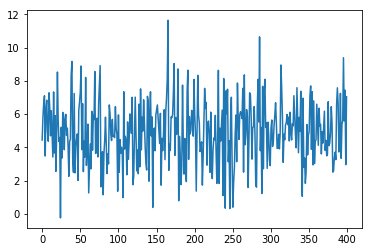

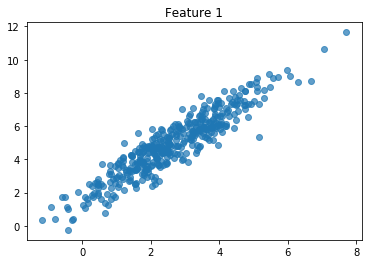

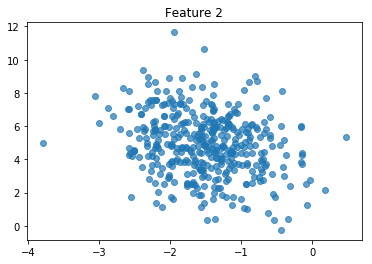

In [48]:
np.random.seed(1704)

# simulate N observations which follow a rough seasonal pattern
N = 400
xseq = np.linspace(1, N, N)

X = np.transpose(
    np.matrix([
        np.ones(N),                                      # bias term 
        np.random.normal(2.7, 1.5, N),                     # feature one
        np.random.normal(-1.5, 0.6, N)                     # feature two
]))

# "ground truth" effects
# these are the parameters that we will attempt to recover
betas = np.matrix([
    np.random.normal(0.4, 0.15, N),           # THE INTERCEPT
    np.random.normal(1.2, 0.5, N),           # effect of feature one
    np.random.normal(-0.85, 0.15, N)          # effect of feature two
])
ground_truth_betas = np.mean(betas, axis=1)
print(ground_truth_betas)

# create a response variable, which is a function of our Xs + noise
y = np.mean(np.matmul(X, betas), axis=1)
y = tf.convert_to_tensor(y.reshape(N), dtype=np.float32).numpy()[0]
y += np.random.normal(0, 0.5, N)

plt.plot(range(N), y)
plt.show()

plt.scatter(tf.convert_to_tensor(X[::,1].reshape(N)), y, alpha=0.7)
plt.title("Feature 1")
plt.show()

plt.scatter(tf.convert_to_tensor(X[::,2].reshape(N)), y, alpha=0.7)
plt.title("Feature 2")
plt.show()

We can see that our `ys` have a strong positive correlation with Feature 1 and a weaker negative correlation with Feature 2. Let's try to code this up.

Our model will have the following form:

$$
y \sim Normal(\mu, \sigma)  \\
\mu = \beta_0 + \beta_1X1 + \beta_2X2 \\
\beta_0, \beta_1, \beta_2 \sim Normal(0.0, 1.0) \\
\sigma \sim HalfCauchy(0, 1)
$$

We should be able to code this into our joint_log_prob function pretty much word-for-word:

In [0]:
reset_sess()

def joint_log_prob(x1, x2, y, beta0, beta1, beta2, sigma):
  
  prior_sigma = tfd.HalfCauchy(0.0, 1.0)
  prior_beta0 = tfd.Normal(0., 5.)
  prior_beta1 = tfd.Normal(0., 5.)
  prior_beta2 = tfd.Normal(0., 5.)
  
  mu = beta0 + beta1*x1 + beta2*x2
  rv_y = tfd.Normal(loc = mu, scale = sigma)
  
  return (
      prior_sigma.log_prob(sigma) +
      prior_beta0.log_prob(beta0) +
      prior_beta1.log_prob(beta1) +
      prior_beta2.log_prob(beta1) +
      tf.reduce_sum(rv_y.log_prob(y)) 
  )

unnormalized_posterior = \
  lambda beta0, beta1, beta2, sigma: joint_log_prob(x1, x2, y, beta0, beta1, beta2, sigma)


This is a little larger than our previous examples, so I am going to increase the length of the chain as we run this (this is why I parametised the number of iterations when I set this up originally)...

/usr/local/lib/python3.6/dist-packages/tensorflow_probability/python/mcmc/sample.py:335: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn("Tracing all kernel results by default is deprecated. Set "


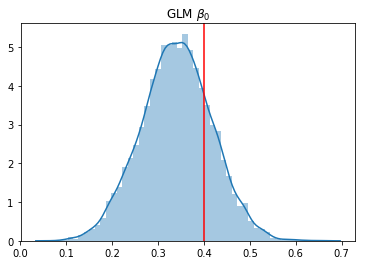

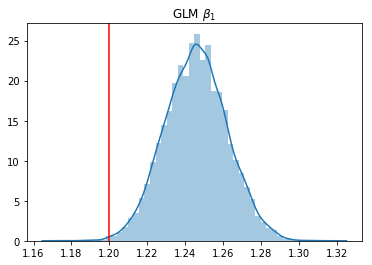

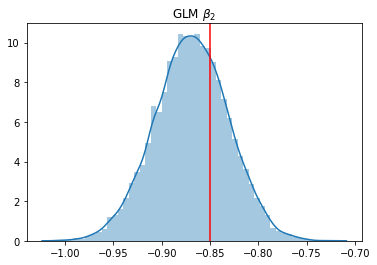

In [53]:
[x1, x2, y] = [
    tf.convert_to_tensor(X[::,1].reshape(N), dtype=np.float32),
    tf.convert_to_tensor(X[::,2].reshape(N), dtype=np.float32),
    y
]

[beta0_, beta1_, beta2_, sigma_] = run_chain(
    construct_hmc(unnormalized_posterior, adaptation_steps = 5000), 
    inits=[0.1, 1.0, -1.0, 0.1],
    iters = [20000, 10000]
)

sns.distplot(beta0_)
plt.axvline(x = 0.4, color='red')
plt.title("GLM $\\beta_0$".format(np.mean(beta0_)))
plt.show()

sns.distplot(beta1_)
plt.axvline(x = 1.2, color='red')
plt.title("GLM $\\beta_1$".format(np.mean(beta1_)))
plt.show()

sns.distplot(beta2_)
plt.axvline(x = -0.85, color='red')
plt.title("GLM $\\beta_2$".format(np.mean(beta2_)))
plt.show()

The parameter estimates are reasonable. They're not perfect, and this is most likely due to the noise or something sloppy in my siulation. But, the true values are all very close to our estimates (don't belive me (especially for beta1)?, just have a look at the scales - they are all very close).

Let's see what the predictions look like. I've defined a helper function below and pltoted the actuals vs. the predicted:

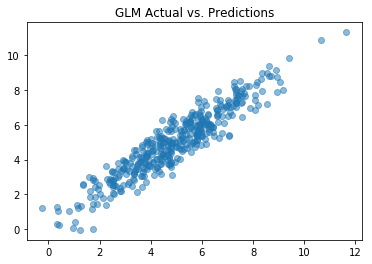

In [55]:
def prediction(x1, x2, b0, b1, b2, sigma):
  
  n_ = x1.shape[0]
  sampler = lambda z: np.random.choice(z, n_, replace=True)
  
  yhat = np.random.normal(
      sampler(b0) + sampler(b1)*x1 + sampler(b2)*x2,
      sampler(sigma)
  )
  
  return yhat

predictions = prediction(x1, x2, beta0_, beta1_, beta2_, sigma_)
predictions.shape

plt.scatter(y, predictions, alpha=0.5)
plt.title("GLM Actual vs. Predictions")
plt.show()

More than happy with this :) 

## Recap  

Finally managed to wrap my head around how to run a Monte Carlo chain in tensorflow probability. Nice! In the end, it was very simple:  

  - define the chain  
  - create a `run_chain()` function (for convenience really)  
  - define the `joint_log_prob()` function  
  
And that's it! Super happy with this and the syntax wasn't nearly as scary as I thought. Odd that the tutorials are so complex??? But very happy what we have here.